# CSC2611 Lab: Word embedding and semantic change

Student Name: Jun Xing  
UtoID: xingjun  
Link to the GitHub repository: https://github.com/JunXing2633/CSC2611


In [1]:
import pickle
import pandas as pd
import numpy as np
import statistics
from gensim.models import KeyedVectors
from scipy import stats,sparse
from scipy.spatial import distance
from nltk.util import ngrams
from nltk.corpus import brown
from collections import Counter
from tqdm import tqdm, trange
from tqdm.contrib import tzip
from decimal import Decimal
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

c:\Users\royxj\miniconda3\envs\boc1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1 Synchronic word embedding [7 points]

In [2]:
# Step 1: Load data from exercise
datapath="./data/"
Pair = pickle.load(open(datapath+"P.pickle",'rb'))
human_jud = pickle.load(open(datapath+"S.pickle",'rb'))
rg65 = pickle.load(open(datapath+"rg65.pickle",'rb'))
w = pickle.load(open(datapath+"w.pickle",'rb'))  # 5000 most common English words based on unigram frequencies in the Brown corpus 

df = pd.DataFrame(Pair, columns =['First_word', 'Second_word'])
df["human-judged similarities"] = human_jud

w.extend(rg65)
w_updated= list(set(w))
print(f"Updated W has {len(w_updated)} words.","\nThe common pairs of words used in all analyses are:\n",df)

Updated W has 5030 words. 
The common pairs of words used in all analyses are:
     First_word Second_word  human-judged similarities
0         cord       smile                       0.02
1      rooster      voyage                       0.04
2         noon      string                       0.04
3        fruit     furnace                       0.05
4    autograph       shore                       0.06
..         ...         ...                        ...
59     cushion      pillow                       3.84
60    cemetery   graveyard                       3.88
61  automobile         car                       3.92
62      midday        noon                       3.94
63         gem       jewel                       3.94

[64 rows x 3 columns]


In [3]:
# Step 2: Construct word embedding models

def construct_models(W):
    '''
    Input: set of words W in a vocabulary

    output: 
    1. constructed model M1, word-context vector model  by collecting bigram counts for words in W
    2. word to index and index to word dictionary
    3. Positive pointwise mutual information on M1, denoted as M1_plus
    4. M2_10, latent semantic model by applying principal components analysis to M1+ truncated dimentsion at 10
    5. M2_100, latent semantic model by applying principal components analysis to M1+ truncated dimentsion at 100
    6. M2_300, latent semantic model by applying principal components analysis to M1+ truncated dimentsion at 300
    6. pretrained word2vec 

    '''

    if os.path.isfile(datapath+'M1.pickle'):
        
        M1 = pickle.load(open(datapath+"M1.pickle","rb"))   
        word_2_index = pickle.load(open(datapath+"word_2_index.pickle","rb"))
        index_2_word = pickle.load(open(datapath+"index_2_word.pickle","rb"))
        M1_plus=pickle.load(open(datapath+"M1_plus.pickle","rb"))  
    else:
        bigrams = Counter(ngrams([word.lower() for word in brown.words()], 2))
        M1 = sparse.lil_matrix((len(W), len(W)))
        word_2_index = {}
        index_2_word = {}

        for i ,w1 in enumerate(tqdm(W)):
            word_2_index[w1.lower()] = i
            index_2_word[i] = w1.lower()
            for j, w2 in enumerate(W):
                M1[i, j] = bigrams[(w1.lower(), w2.lower())]
        
        pickle.dump(M1, open(datapath+"M1.pickle","wb"))
        pickle.dump(word_2_index, open(datapath+"word_2_index.pickle","wb"))
        pickle.dump(index_2_word, open(datapath+"index_2_word.pickle","wb"))

        unigram = Counter(ngrams([word.lower() for word in brown.words()], 1))
        M1_plus = sparse.lil_matrix((len(w_updated), len(w_updated)))
        count_all_words = len(brown.words())
        nonzero_i, nonzero_j = M1.nonzero()
        for i, j in tzip(nonzero_i, nonzero_j):

            count1 = unigram[(index_2_word[i],)]
            count2 = unigram[(index_2_word[j],)]

            P1 =  count1 / count_all_words
            P2 =  count2 / count_all_words
            P1_2 = (M1[i, j]) / (M1.sum())
            M1_plus[i, j] = max(0, np.log( P1_2 / (P1 * P2)))

        pickle.dump(M1_plus, open(datapath+"M1_plus.pickle","wb"))
    
    print(f"M1 has a shape of {M1.shape}")
    print(f"M1_plus has a shape of {M1_plus.shape}")
    
    # PCA on sparse matrix
    M2_10 = TruncatedSVD(n_components=10, random_state=666).fit_transform(M1_plus)
    M2_100 = TruncatedSVD(n_components=100, random_state=666).fit_transform(M1_plus)
    M2_300 = TruncatedSVD(n_components=300, random_state=666).fit_transform(M1_plus)

    # model w2v googlenews pretarined negative 300
    w2v_pretrained = KeyedVectors.load_word2vec_format(datapath+'GoogleNews-vectors-negative300.bin.gz', binary=True) 
    
    return M1,word_2_index,index_2_word,M1_plus, M2_10, M2_100, M2_300, w2v_pretrained

M1,word_2_index,index_2_word,M1_plus, M2_10, M2_100, M2_300, w2v_pretrained = construct_models(W=w_updated)


M1 has a shape of (5030, 5030)
M1_plus has a shape of (5030, 5030)


In [4]:

M1 = pickle.load(open(datapath+"M1.pickle","rb"))   
word_2_index = pickle.load(open(datapath+"word_2_index.pickle","rb"))
index_2_word = pickle.load(open(datapath+"index_2_word.pickle","rb"))
M1_plus=pickle.load(open(datapath+"M1_plus.pickle","rb"))
df_M1 = pd.DataFrame.sparse.from_spmatrix(data = M1, index = word_2_index, columns = word_2_index)
df_M1

,outside,seen,guilt,does,chemical,theme,window,enforcement,tangent,pope,...,voluntary,circles,could,distances,exist,decent,massachusetts,districts,access,interest
outside,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
seen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
guilt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
does,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
chemical,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
decent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
massachusetts,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
districts,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
access,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df_M1_plus = pd.DataFrame.sparse.from_spmatrix(data = M1_plus, index = word_2_index, columns = word_2_index)
df_M1_plus

,outside,seen,guilt,does,chemical,theme,window,enforcement,tangent,pope,...,voluntary,circles,could,distances,exist,decent,massachusetts,districts,access,interest
outside,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
seen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
guilt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
does,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.02044,0.0,0.0,0.0,0.0,0.0
chemical,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
decent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
massachusetts,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
districts,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
access,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0


In [6]:
df_M2_10 = pd.DataFrame(data = M2_10, index = word_2_index)
df_M2_10

,0,1,2,3,4,5,6,7,8,9
outside,3.874438,0.803934,-1.810792,1.149013,1.107951,-1.250064,1.902354,1.300893,0.040412,0.420604
seen,5.258244,-4.236508,-1.850233,4.818149,2.393508,-0.450808,1.018369,-1.258560,-0.745765,-0.493929
guilt,2.600411,-3.481472,-1.567675,-0.325477,-0.405340,0.439600,-0.484862,-0.013232,0.028681,0.082001
does,3.731283,-0.832924,2.082284,1.144864,5.268524,-1.670770,0.217214,1.548500,-0.553338,-0.527616
chemical,2.562249,2.162954,-1.556808,-1.365086,-0.554084,-0.660413,0.453128,-0.122109,-2.440434,-0.745986
...,...,...,...,...,...,...,...,...,...,...
decent,1.726032,0.837540,-0.853552,-0.146222,-0.183437,-0.134931,0.120748,-0.574950,-0.473440,-1.326989
massachusetts,1.642557,-0.947357,-0.414157,-0.505557,-0.406189,0.654516,-0.105402,0.420583,-0.059709,-0.228391
districts,2.078305,-2.370144,-0.806275,-0.499490,0.194369,0.288268,-0.378666,0.386752,-0.058738,-0.026791
access,1.695012,-1.763429,-1.256899,-0.184123,0.000690,0.074360,-0.242462,-0.360921,-0.747400,-0.055897


In [7]:
# Calculate cosine distance between each pair of word embeddings
# Report the Pearson correlation between word2vec-based and human similarities
similar_M1 = []
similar_M1_plus = []
similar_M2_10 = []
similar_M2_100 = []
similar_M2_300 = []
similar_w2v=[]

for i,j in tzip([p[0] for p in Pair],[p[1] for p in Pair]):
  
  similar_M1.append(cosine_similarity(M1[word_2_index[i]].reshape(1, -1),M1[word_2_index[j]].reshape(1, -1))[0][0])
  similar_M1_plus.append(cosine_similarity(M1_plus[word_2_index[i]].reshape(1, -1),M1_plus[word_2_index[j]].reshape(1, -1))[0][0])
  similar_M2_10.append(cosine_similarity(M2_10[word_2_index[i]].reshape(1, -1),M2_10[word_2_index[j]].reshape(1, -1))[0][0])
  similar_M2_100.append(cosine_similarity(M2_100[word_2_index[i]].reshape(1, -1),M2_100[word_2_index[j]].reshape(1, -1))[0][0])
  similar_M2_300.append(cosine_similarity(M2_300[word_2_index[i]].reshape(1, -1),M2_300[word_2_index[j]].reshape(1, -1))[0][0])
  similar_w2v.append(cosine_similarity(w2v_pretrained[i].reshape(1,-1),w2v_pretrained[j].reshape(1,-1))[0][0])

pearson_M1=stats.pearsonr(human_jud, similar_M1)
pearson_M1_plus=stats.pearsonr(human_jud, similar_M1_plus)
pearson_w2v=stats.pearsonr(human_jud, similar_w2v)
pearson_M2_10=stats.pearsonr(human_jud, similar_M2_10)
pearson_M2_100=stats.pearsonr(human_jud, similar_M2_100)
pearson_M2_300=stats.pearsonr(human_jud, similar_M2_300)

print(f"Pearson correlation between word2vec-based and human judgement are {round(pearson_w2v[0],3)} with p_value of {Decimal(pearson_w2v[1]):.3E}")
print(f"Pearson correlation between M1-based and human judgement are {round(pearson_M1[0],3)} with p_value of {Decimal(pearson_M1[1]):.3E}")
print(f"Pearson correlation between M1_plus-based and human judgement are {round(pearson_M1_plus[0],3)} with p_value of {Decimal(pearson_M1_plus[1]):.3E}")
print(f"Pearson correlation between M2_10-based and human judgement are {round(pearson_M2_10[0],3)} with p_value of {Decimal(pearson_M2_10[1]):.3E}")
print(f"Pearson correlation between M2_100-based and human judgement are {round(pearson_M2_100[0],3)} with p_value of {Decimal(pearson_M2_100[1]):.3E}")
print(f"Pearson correlation between M2_300-based and human judgement are {round(pearson_M2_300[0],3)} with p_value of {Decimal(pearson_M2_300[1]):.3E}")

100%|██████████| 64/64 [00:00<00:00, 181.21it/s]

Pearson correlation between word2vec-based and human judgement are 0.769 with p_value of 1.148E-13
Pearson correlation between M1-based and human judgement are 0.324 with p_value of 8.986E-3
Pearson correlation between M1_plus-based and human judgement are 0.211 with p_value of 9.456E-2
Pearson correlation between M2_10-based and human judgement are 0.179 with p_value of 1.580E-1
Pearson correlation between M2_100-based and human judgement are 0.302 with p_value of 1.544E-2
Pearson correlation between M2_300-based and human judgement are 0.339 with p_value of 6.145E-3


#### Comment on this value in comparison to those from LSA and word-context vectors from analyses in the earlier exercise.

By comparing Pearson correlations between human adjustments and different models. We notice that word2vec generates much higher pearson correlation(0.769) than the other models.  
We can conclude that embeddings from word2vec are more representative regards the words' meaning and association.  
 
Also, as we increase dimensions of PCA, the word embedding yields better representation, so the higher Pearson correlation to the human judgement. 


In [8]:
import requests
analogy_data = requests.get('http://www.fit.vutbr.cz/~imikolov/rnnlm/word-test.v1.txt')

In [9]:
file=analogy_data.text.split('\n')[1:]
Analogy_tests_dict = {}
for line in file:
  words_list = line.lower().split()
  if len(words_list)<1:
    pass
  elif words_list[0]==":":
    types_test = words_list[-1].strip()
    Analogy_tests_dict[types_test]=[]

  elif len(words_list) == 4 and (words_list[0] in w_updated) and (words_list[1] in w_updated) \
    and (words_list[2] in w_updated) and (words_list[3] in w_updated):
    Analogy_tests_dict[types_test].append((words_list[0], words_list[1], words_list[2], words_list[3]))


In [10]:
semantic_test = []
syntactic_test = []

for i in Analogy_tests_dict:
    if i.startswith("gram"):
        syntactic_test.extend(Analogy_tests_dict[i])
    else:
        semantic_test.extend(Analogy_tests_dict[i])
    print(i,":", len(Analogy_tests_dict[i]),"tests")

Analogy_tests_dict.pop("currency", None)

print("\nThe small test set I considered are the ones that all four words appear in W, which we used previously.")
print(f"Total semantic tests： {len(semantic_test)}")
print(f"Total syntactic tests： {len(syntactic_test)}")

capital-common-countries : 20 tests
capital-world : 6 tests
currency : 0 tests
city-in-state : 59 tests
family : 90 tests
gram1-adjective-to-adverb : 380 tests
gram2-opposite : 20 tests
gram3-comparative : 272 tests
gram4-superlative : 42 tests
gram5-present-participle : 272 tests
gram6-nationality-adjective : 87 tests
gram7-past-tense : 600 tests
gram8-plural : 306 tests
gram9-plural-verbs : 132 tests

The small test set I considered are the ones that all four words appear in W, which we used previously.
Total semantic tests： 175
Total syntactic tests： 2111


In [11]:
# prepare txt format that is consistent with "questions-words.txt" file available from the original word2vec.c distribution 
# so that API evaluate word analogies can be used for analogy tests

with open(datapath+"semantic_tests.txt", "w") as f1:
    for ele in Analogy_tests_dict:
        if not ele.startswith("gram"):
            f1.write(f": {ele}\n")
            for words in Analogy_tests_dict[ele]:
                
                f1.write(f"{words[0]}\t")
                f1.write(f"{words[1]}\t")
                f1.write(f"{words[2]}\t")
                f1.write(f"{words[3]}\n")    
f1.close()
with open(datapath+"syntactic_tests.txt", "w") as f2:
    for ele in Analogy_tests_dict:
        if ele.startswith("gram"):
            f2.write(f": {ele}\n")
            for words in Analogy_tests_dict[ele]:
                f2.write(f"{words[0]}\t")
                f2.write(f"{words[1]}\t")
                f2.write(f"{words[2]}\t")
                f2.write(f"{words[3]}\n")    
f2.close()

lsa_M2_300 = KeyedVectors(vector_size=300)
lsa_M2_300.add_vectors(keys=list(word_2_index.keys()), weights=M2_300)

semantic_acc_w2v = w2v_pretrained.evaluate_word_analogies(datapath+'semantic_tests.txt')
syntactic_acc_w2v = w2v_pretrained.evaluate_word_analogies(datapath+'syntactic_tests.txt')
semantic_acc_lsa = lsa_M2_300.evaluate_word_analogies(datapath+'semantic_tests.txt')
syntactic_acc_lsa = lsa_M2_300.evaluate_word_analogies(datapath+'syntactic_tests.txt')

print(f"Word2vec yields a accuracy of {round(semantic_acc_w2v[0]*100,3)}% on the {len(semantic_test)} semantic analogy tests.")
print(f"Word2vec yields a accuracy of {round(syntactic_acc_w2v[0]*100,3)}% on the {len(syntactic_test)} syntactic analogy tests.")
print(f"LSA_M2_300 yields a accuracy of {round(semantic_acc_lsa[0]*100,3)}% on the {len(semantic_test)} semantic analogy tests.")
print(f"LSA_M2_300 yields a accuracy of {round(syntactic_acc_lsa[0]*100,3)}% on the {len(syntactic_test)} syntactic analogy tests.")

Word2vec yields a accuracy of 88.0% on the 175 semantic analogy tests.
Word2vec yields a accuracy of 68.593% on the 2111 syntactic analogy tests.
LSA_M2_300 yields a accuracy of 8.571% on the 175 semantic analogy tests.
LSA_M2_300 yields a accuracy of 7.39% on the 2111 syntactic analogy tests.


Discussion:  

As the results shown above, we can tell that word2vec outperforms LSA_M2_300 in both semantic and syntactic analogy tests.
Even though the two embedding vector representation has the same dimension (300), but word2vec embeddings was trained on much larger dataset.
Therefore, it embeddings are more representative of word meaning and association.
   

#### Suggest a way to improve the existing set of vector-based models in capturing word similarities in general, and provide justifications for your suggestion.    

1. In general, we can try to use larger training dataset, larger language model, and increase the dimension of a vector representation. As a result, such embedding vector are more representative by its context, leads to better capture of the word similarities. However, it also means longer training time and more computational resources. 

2. Second of all, outside the model, we can use engineering techniques such as "preprocess" and "postprocess". For example, we can do lemmatization/steamming to treat words with different morphology forms to same token. We can use black/white list to enforce rules that artificailly increase the word similarities. We can use Part of Speech tags so that word with multiple unrelated senses can be treated as different token. Therefore, the model as a whole, would be able to capture word similarities better.

## 2 Diachronic word embedding [8 points]

Step 1. Download the diachronic word2vec embeddings from the course syllabus page. These embeddings capture historical usage of a small subset of English words over the past century

In [12]:
diachronic_data = pickle.load(open(datapath+"data.pkl","rb"))
diachronic_words=diachronic_data['w']
diachronic_decades=diachronic_data['d']
diachronic_vectors=diachronic_data['E']
print(len(set(diachronic_words))) #confirm all words are unique
print(diachronic_decades)

2000
[1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990]


In [13]:
from sklearn.neighbors import NearestNeighbors

def get_nearest_neighbor(word,year,k):
    # This is a helper function which gets k nearest neighbor words
    if word not in diachronic_words or year not in diachronic_decades:
        return []
    
    word_idx = diachronic_words.index(word)
    yr_idx = diachronic_decades.index(year)

    matrix_year = []
    for i in range(len(diachronic_vectors)):
        matrix_year.append(diachronic_vectors[i][yr_idx])
    matrix_year = np.array(matrix_year)

    knn_temp = NearestNeighbors(n_neighbors=k)
    knn_temp.fit(matrix_year)

    vector_temp = diachronic_vectors[word_idx][yr_idx].reshape(1, -1)
    neighbor_idx = knn_temp.kneighbors(vector_temp,k,return_distance=False)
    
    ret = [diachronic_words[i] for i in list(neighbor_idx)[0]]
    ret.remove(word)
    return ret

def cal_jaccard(list_a,list_b):
    # This is a helper function which calculates jaccard distances
    intersect = set(list_a).intersection(list_b)
    union = len(list_a)+len(list_b)-len(intersect)
    ret = 1-len(intersect)/union
    return ret

    

Step 2. Propose three different methods for measuring degree of semantic change for individual words and report the top 20 most and least changing words in table(s) from each measure.

In [14]:
def methods_semantic_change(word,method):

    '''
    This is the main function 
    input: 
    1. word: a word (string) for which we need to quantify the semantic change between 1900 and 1990
    2. method: int to represent which method to use 
            method 1: consider the change(cosine-distance) of the two end points, Larger the cosine distance, larger the semantic change
            mehotd 2: cosider the average of the changes(cosine-distance) of over 10 years. Larger the average, larger the semantic change.
            method 3: cosider the standard deviation of the changes(cosine-distance) of over 10 years. Larger the std, larger the semantic change.
            method 4: This is the proposed procedure to evaluate accuracy of method 1-3, It considers jaccard distance between set of neareast neighbors.
    output:
    semantic change as defined
    
    '''
    idx = diachronic_words.index(word)
    embed1 = diachronic_vectors[idx][0]
    embed2 = diachronic_vectors[idx][-1]
    if method==1:
        return distance.cosine(embed1,embed2)
    elif method==2:
        temp=[]
        for i in range(len(diachronic_vectors[idx])-1):
            temp.append(distance.cosine(diachronic_vectors[idx][i],diachronic_vectors[idx][i+1]))
        return sum(temp)/len(temp)
    elif method==3:
        temp=[]
        for i in range(len(diachronic_vectors[idx])-1):
            temp.append(distance.cosine(diachronic_vectors[idx][i],diachronic_vectors[idx][i+1]))
        return statistics.stdev(temp)    
        
    elif method==4:
        list_a = get_nearest_neighbor(word,year=1900,k=26)
        list_b = get_nearest_neighbor(word,year=1990,k=26)
    
        return cal_jaccard(list_a,list_b)
    


In [15]:
semantic_change_method1={}
semantic_change_method2={}
semantic_change_method3={}
for word in diachronic_words:
    semantic_change_method1[word]=methods_semantic_change(word,method=1)
    semantic_change_method2[word]=methods_semantic_change(word,method=2)
    semantic_change_method3[word]=methods_semantic_change(word,method=3)
    
top20_method1 = sorted(semantic_change_method1, key=semantic_change_method1.get, reverse=True)[:20]
bottom20_method1 = sorted(semantic_change_method1, key=semantic_change_method1.get, reverse=False)[:20]
top20_method2 = sorted(semantic_change_method2, key=semantic_change_method2.get, reverse=True)[:20]
bottom20_method2 = sorted(semantic_change_method2, key=semantic_change_method2.get, reverse=False)[:20]
top20_method3 = sorted(semantic_change_method3, key=semantic_change_method3.get, reverse=True)[:20]
bottom20_method3 = sorted(semantic_change_method3, key=semantic_change_method3.get, reverse=False)[:20]

In [16]:
df_most_changing=pd.DataFrame({"Method_1":top20_method1,"Method_2":top20_method2,"Method_3":top20_method3})
print("The top 20 most changing words by each method are:")
df_most_changing.transpose()

The top 20 most changing words by each method are:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Method_1,programs,objectives,computer,radio,sector,goals,approach,van,shri,media,impact,perspective,patterns,berkeley,shift,film,assessment,stanford,challenge,therapy
Method_2,harper,jones,sector,berkeley,wiley,baltimore,martin,princeton,wilson,adams,therapy,johnson,goals,haven,philip,evaluation,j,publications,stanford,maryland
Method_3,goals,objectives,computer,programs,sector,evaluation,input,techniques,therapy,mcgraw,shri,procedures,ml,skills,variables,radio,jobs,subsection,implications,technology


In [17]:
df_least_changing=pd.DataFrame({"Method_1":bottom20_method1,"Method_2":bottom20_method2,"Method_3":bottom20_method3})
print("The bottom 20 least changing words by each method are:")
df_least_changing.transpose()

The bottom 20 least changing words by each method are:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Method_1,techniques,skills,mcgraw,ml,april,june,november,february,years,october,increase,january,century,months,daughter,december,god,september,feet,week
Method_2,shri,april,miles,november,september,january,december,february,university,vessels,trees,cent,solution,july,decrease,october,temperature,buildings,june,patients
Method_3,november,increase,reply,article,card,root,calcium,rome,jurisdiction,situation,president,act,pair,father,force,bath,troops,night,remainder,sunday


Measure the intercorrelations (of semantic change in all words, given the embeddings from Step 1) among the three methods you have proposed and summarize the Pearson
correlations in a 3-by-3 table

In [18]:
method1_distances = []
method2_distances = []
method3_distances = []
for word in diachronic_words:
    method1_distances.append(semantic_change_method1[word])
    method2_distances.append(semantic_change_method2[word])
    method3_distances.append(semantic_change_method3[word])

pearsonr_method1_2=round((stats.pearsonr(method1_distances, method2_distances))[0],3)
pearsonr_method2_3=round((stats.pearsonr(method2_distances, method3_distances))[0],3)
pearsonr_method3_1=round((stats.pearsonr(method3_distances, method1_distances))[0],3)

In [36]:
print(f"The numpy cross-correlation between results from Method 1 and Method 2 is {round(np.correlate(method1_distances,method2_distances)[0],3)}")
print(f"The numpy cross-correlation between results from Method 2 and Method 3 is {round(np.correlate(method2_distances,method3_distances)[0],3)}")
print(f"The numpy cross-correlation between results from Method 1 and Method 3 is {round(np.correlate(method3_distances,method1_distances)[0],3)}")

The numpy cross-correlation between results from Method 1 and Method 2 is 245.228
The numpy cross-correlation between results from Method 2 and Method 3 is 12.551
The numpy cross-correlation between results from Method 1 and Method 3 is 25.775


In [20]:
df_method_corr=pd.DataFrame.from_records([[1,pearsonr_method1_2,pearsonr_method3_1],\
    [pearsonr_method1_2,1,pearsonr_method2_3],\
        [pearsonr_method3_1,pearsonr_method2_3,1]],columns = ["Method_1","Method_2","Method_3"])
df_method_corr["_"]=["Method_1","Method_2","Method_3"]
df_method_corr.set_index(["_"], inplace = True)
print("Pearson correlations of the semantic changes by 3 methods are summarized as following table:\n")
df_method_corr

Pearson correlations of the semantic changes by 3 methods are summarized as following table:



,Method_1,Method_2,Method_3
_,,,
Method_1,1.000,0.64,0.367
Method_2,0.640,1.00,0.360
Method_3,0.367,0.36,1.000


- Method 1 is based on the change(cosine-distance) of the two end points.
- Method 2 is based the average of the changes(cosine-distance) of over 10 years.
- Method 3 is based on the standard deviation of the changes(cosine-distance) of over 10 years.


Step 3. Propose and justify a procedure for evaluating the accuracy of the methods you have
proposed in Step 2, and then evaluate the three methods following this proposed procedure
and report Pearson correlations or relevant test statistics.

Proposed Evaluation:  
The proposed procedure has two parts:   
Part 1: establish a new method to quantify true semantic change 
1. get set of k nearest neighbor in first year
2. get set of k nearest neighbor in final year
3. calculate jaccard distance between the two sets, the greater difference, the larger the semantic change.  

Part 2:
1. compare jaccard similarity between sets of top 20 and bottom 20 from 3 methods and that from proposed method
2. calculate pearson correlation between all distances from 3 methods and that from proposed method   

The rationale is that if the meaning of a word does not change, its neighbor should be approximately the same.
Notice that different values of k have been experimented. Different k results in different top20 and bottom 20 changing words, but it does not change the evaluation of 3 methods.




In [21]:
semantic_change_proposed={}
for word in diachronic_words:
    semantic_change_proposed[word]=methods_semantic_change(word,method=4)

top20_proposed = sorted(semantic_change_proposed, key=semantic_change_proposed.get, reverse=True)[:20]
bottom20_proposed = sorted(semantic_change_proposed, key=semantic_change_proposed.get, reverse=False)[:20]

In [22]:
df_most_changing=pd.DataFrame({"Method_1":top20_method1,"Method_2":top20_method2,"Method_3":top20_method3,"Proposed":top20_proposed})
print("The top 20 most changing words by each method are:")
df_most_changing.transpose()

The top 20 most changing words by each method are:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Method_1,programs,objectives,computer,radio,sector,goals,approach,van,shri,media,impact,perspective,patterns,berkeley,shift,film,assessment,stanford,challenge,therapy
Method_2,harper,jones,sector,berkeley,wiley,baltimore,martin,princeton,wilson,adams,therapy,johnson,goals,haven,philip,evaluation,j,publications,stanford,maryland
Method_3,goals,objectives,computer,programs,sector,evaluation,input,techniques,therapy,mcgraw,shri,procedures,ml,skills,variables,radio,jobs,subsection,implications,technology
Proposed,impact,sector,radio,mcgraw,ml,approach,computer,techniques,signal,skills,assessment,perspective,system,scale,post,programs,film,focus,boundary,objectives


In [23]:
jac_top20_method1_p=round(1-cal_jaccard(top20_method1,top20_proposed),3)
jac_top20_method2_p=round(1-cal_jaccard(top20_method2,top20_proposed),3)
jac_top20_method3_p=round(1-cal_jaccard(top20_method3,top20_proposed),3)
print(f"Jaccard Similaritity Between Top20 by Method 1 and that from Proposed is: {jac_top20_method1_p}")
print(f"Jaccard Similaritity Between Top20 by Method 2 and that from Proposed is: {jac_top20_method2_p}")
print(f"Jaccard Similaritity Between Top20 by Method 3 and that from Proposed is: {jac_top20_method3_p}")

Jaccard Similaritity Between Top20 by Method 1 and that from Proposed is: 0.333
Jaccard Similaritity Between Top20 by Method 2 and that from Proposed is: 0.026
Jaccard Similaritity Between Top20 by Method 3 and that from Proposed is: 0.29


In [24]:
df_least_changing=pd.DataFrame({"Method_1":bottom20_method1,"Method_2":bottom20_method2,"Method_3":bottom20_method3,"Proposed":bottom20_proposed})
print("The bottom 20 least changing words by each method are:")
df_least_changing.transpose()

The bottom 20 least changing words by each method are:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Method_1,techniques,skills,mcgraw,ml,april,june,november,february,years,october,increase,january,century,months,daughter,december,god,september,feet,week
Method_2,shri,april,miles,november,september,january,december,february,university,vessels,trees,cent,solution,july,decrease,october,temperature,buildings,june,patients
Method_3,november,increase,reply,article,card,root,calcium,rome,jurisdiction,situation,president,act,pair,father,force,bath,troops,night,remainder,sunday
Proposed,morning,illinois,iowa,december,summer,wisconsin,kitchen,missouri,indiana,minnesota,autumn,days,south,night,mother,wife,june,january,september,parents


In [25]:
jac_bottom20_method1_p=round(1-cal_jaccard(bottom20_method1,bottom20_proposed),3)
jac_bottom20_method2_p=round(1-cal_jaccard(bottom20_method2,bottom20_proposed),3)
jac_bottom20_method3_p=round(1-cal_jaccard(bottom20_method3,bottom20_proposed),3)
print(f"Jaccard Similaritity Between Bottom20 by Method 1 and that from Proposed is: {jac_bottom20_method1_p}")
print(f"Jaccard Similaritity Between Bottom20 by Method 2 and that from Proposed is: {jac_bottom20_method2_p}")
print(f"Jaccard Similaritity Between Bottom20 by Method 3 and that from Proposed is: {jac_bottom20_method3_p}")

Jaccard Similaritity Between Bottom20 by Method 1 and that from Proposed is: 0.111
Jaccard Similaritity Between Bottom20 by Method 2 and that from Proposed is: 0.111
Jaccard Similaritity Between Bottom20 by Method 3 and that from Proposed is: 0.026


In [26]:
proposed_distances = []
for word in diachronic_words:
    proposed_distances.append(semantic_change_proposed[word])

pearsonr_method1_p=round((stats.pearsonr(method1_distances, proposed_distances))[0],3)
pearsonr_method2_p=round((stats.pearsonr(method2_distances, proposed_distances))[0],3)
pearsonr_method3_p=round((stats.pearsonr(method3_distances, proposed_distances))[0],3)

df_method_corr=pd.DataFrame.from_records([[1,pearsonr_method1_2,pearsonr_method3_1,pearsonr_method1_p],\
    [pearsonr_method1_2,1,pearsonr_method2_3,pearsonr_method2_p],\
        [pearsonr_method3_1,pearsonr_method2_3,1,pearsonr_method3_p],\
            [pearsonr_method1_p,pearsonr_method2_p,pearsonr_method3_p,1]],columns = ["Method_1","Method_2","Method_3","Proposed"])
df_method_corr["_"]=["Method_1","Method_2","Method_3","Proposed"]
df_method_corr.set_index(["_"], inplace = True)
print("Pearson correlations of the semantic changes by 3 methods and proposed evaluation are summarized as following table:\n")
df_method_corr

Pearson correlations of the semantic changes by 3 methods and proposed evaluation are summarized as following table:



,Method_1,Method_2,Method_3,Proposed
_,,,,
Method_1,1.000,0.640,0.367,0.416
Method_2,0.640,1.000,0.360,0.164
Method_3,0.367,0.360,1.000,0.237
Proposed,0.416,0.164,0.237,1.000


Based on Jaccard Similaritity and Pearson Correlations with proposed evaluation, Method_1 outperforms the other two methods. 

Step 4. Extract the top 3 changing words using the best method from Steps 2 and 3. Propose
and implement a simple way of detecting the point(s) of semantic change in each word based
on its diachronic embedding time course—visualize the time course and the detected change
point(s)

In [27]:
top1,top2,top3=top20_proposed[:3]
print(f"Top 3 chaning words using best method are {top1},{top2},and {top3}.")

Top 3 chaning words using best method are impact,sector,and radio.


The strategy of detecting changing points is to plot time series of semantic change using both cosine distance of two embeddings and jaccard distance of two sets of nearest neighbors. 

In [28]:
    def plot_semantic_change_series(word):
        # This is helper function which plots the semantic change over 10 years
        idx = diachronic_words.index(word)
        temp_method1=[0]
        temp_method4=[0]
        for i in range(len(diachronic_vectors[idx])-1):
            temp_method1.append(distance.cosine(diachronic_vectors[idx][i],diachronic_vectors[idx][i+1]))
            la=get_nearest_neighbor(word,year=diachronic_decades[i],k=26)
            lb=get_nearest_neighbor(word,year=diachronic_decades[i+1],k=26)
            temp_method4.append(cal_jaccard(la,lb))
        
        df_result = pd.DataFrame({"Year":diachronic_decades,"Cosine Distance":temp_method1,"Jaccard Distance":temp_method4})
        #df_result.set_index("Year",inplace=True)
        figure, axes = plt.subplots(1, 2)
        figure.set_figheight(6)
        figure.set_figwidth(20)
        figure.suptitle(f"Semantic Change of \"{word}\" from Year {diachronic_decades[0]} to {diachronic_decades[-1]}", fontsize=16)

        df_result[['Year', 'Jaccard Distance']].plot(x='Year', grid=True, marker='o',ax=axes[0])
        df_result[['Year', 'Cosine Distance']].plot(x='Year', kind='bar',ax=axes[1])
        
        plt.show()
        


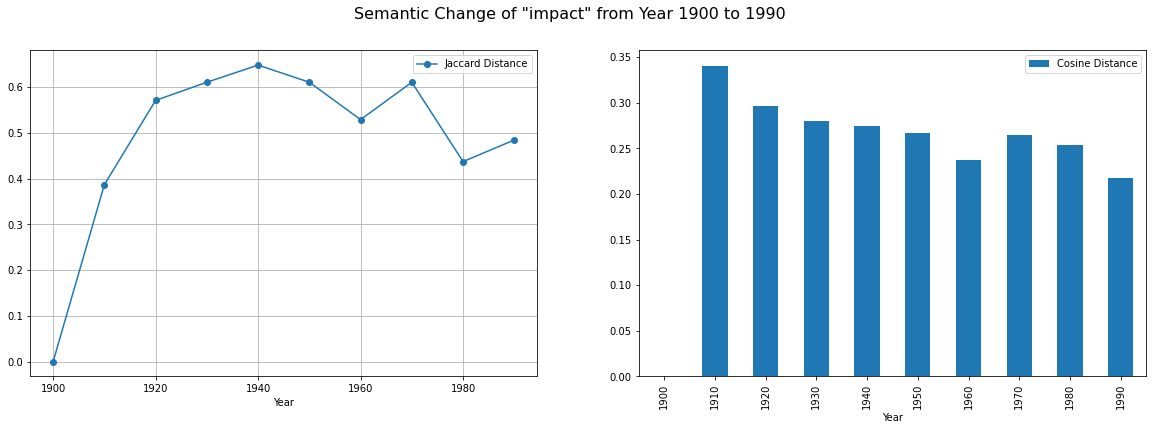

In [29]:
plot_semantic_change_series(word=top1)

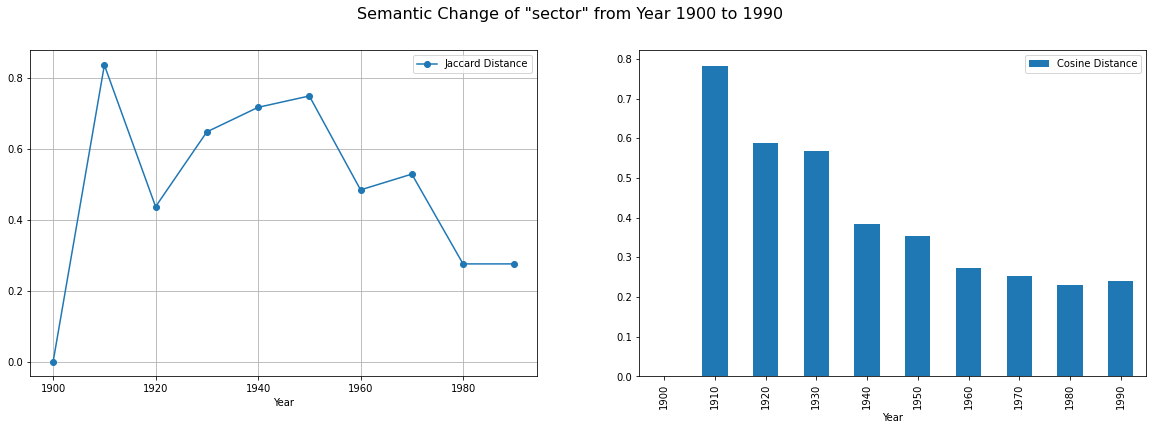

In [30]:
plot_semantic_change_series(word=top2)

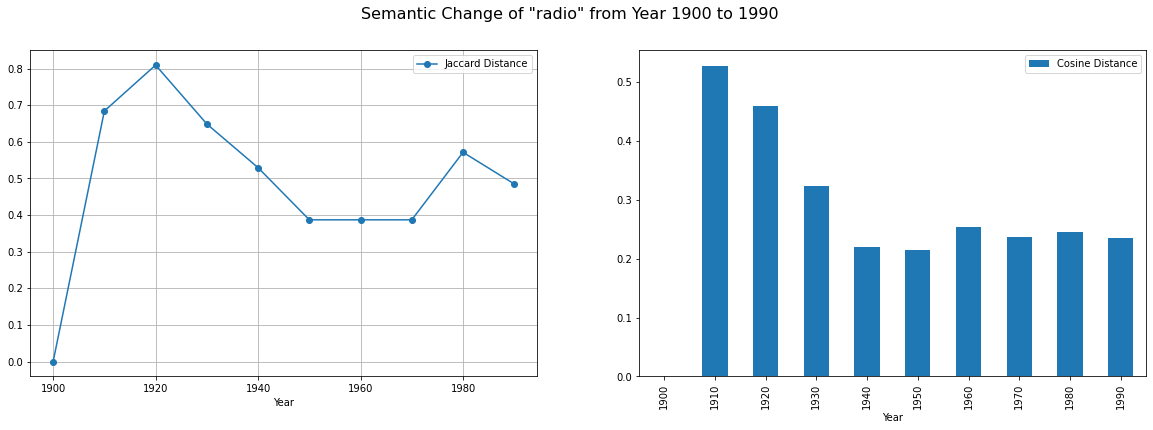

In [31]:
plot_semantic_change_series(word=top3)

Based on the plots above, it seems that all top 3 chaning words have their change points in the first year. Let us confirm by comparing the chaning neighbors.

In [32]:
def confirm_neighbors_change(word):
    a=get_nearest_neighbor(word=word,year=1900,k=26)
    b=get_nearest_neighbor(word=word,year=1910,k=26)
    print(f"The nearest 25 neighbor for \'{word}\' in year 1900 are :\n{a}")
    print(f"The nearest 25 neighbor for \'{word}\' in year 1910 are :\n{b}")
    ret = round(len(set(a).intersection(b))/26*100,1)
    print(f"The overlap portion is {ret}%")
   

In [33]:
confirm_neighbors_change(word=top1)

The nearest 25 neighbor for 'impact' in year 1900 are :
['mcgraw', 'ml', 'techniques', 'skills', 'velocity', 'shock', 'radiation', 'waves', 'particle', 'particles', 'ions', 'molecules', 'electrons', 'pressure', 'intensity', 'rays', 'wave', 'action', 'contact', 'stress', 'motion', 'beam', 'force', 'components', 'wind']
The nearest 25 neighbor for 'impact' in year 1910 are :
['techniques', 'shri', 'ml', 'computer', 'skills', 'velocity', 'shock', 'waves', 'electrons', 'pressure', 'particles', 'molecules', 'rays', 'particle', 'ions', 'wind', 'blow', 'wave', 'force', 'radiation', 'atoms', 'contact', 'component', 'stress', 'effects']
The overlap portion is 73.1%


In [34]:
confirm_neighbors_change(word=top2)

The nearest 25 neighbor for 'sector' in year 1900 are :
['techniques', 'skills', 'ml', 'mcgraw', 'diameter', 'radius', 'area', 'angle', 'circle', 'center', 'input', 'c', 'axis', 'areas', 'h', 'size', 'sphere', 'k', 'base', 'management', 'r', 'p', 'cylinder', 'fig', 'n']
The nearest 25 neighbor for 'sector' in year 1910 are :
['shri', 'ml', 'computer', 'skills', 'techniques', 'front', 'corps', 'centre', 'area', 'divisions', 'portion', 'division', 'line', 'circle', 'radius', 'wing', 'center', 'border', 'troops', 'zone', 'north', 'commander', 'command', 'curve', 'south']
The overlap portion is 26.9%


In [35]:
confirm_neighbors_change(word=top3)

The nearest 25 neighbor for 'radio' in year 1900 are :
['techniques', 'skills', 'ml', 'mcgraw', 'electrons', 'substances', 'interaction', 'properties', 'activity', 'radiation', 'fluid', 'electron', 'nerve', 'atoms', 'substance', 'tissues', 'processes', 'molecules', 'correlation', 'atom', 'equilibrium', 'reactions', 'elements', 'bodies', 'absorption']
The nearest 25 neighbor for 'radio' in year 1910 are :
['computer', 'skills', 'techniques', 'shri', 'ml', 'substances', 'compounds', 'properties', 'elements', 'phenomena', 'activity', 'telephone', 'interaction', 'processes', 'electricity', 'atoms', 'energy', 'engineers', 'particles', 'bodies', 'frequency', 'reactions', 'metals', 'institute', 'structures']
The overlap portion is 46.2%
